In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
import os
import seaborn as sns
import pandas as pd
from tf_util.families import family_from_str
from plot_util import EFN_model_df, find_last_ind, get_latest_diagnostics
from efn_util import setup_IO, find_convergence, model_opt_hps

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

basedir = '/Users/sbittner/Documents/efn/';
dir_str = 'test'

exp_fam = 'inv_wishart';

datadir = '/Users/sbittner/Documents/efn/results/dim_sweep/';
D = 4;
model = 'EFN';
L = 4;
give_hint = False;
        
ds = 0;
K = 100;
M = 1000;

rs = 0;
wsize = 50;
delta_thresh = 1e-10;

max_iters = 1000000;
min_iters = 50000;
check_rate = 100;
max_checks = np.int(max_iters // check_rate);
min_checks = np.int(min_iters // check_rate);

        
if (D >= 20):
    min_iters = 100000;
else:
    min_iters = 50000;


fam_class = family_from_str(exp_fam);
family = fam_class(D);
D_Z, num_suff_stats, num_param_net_inputs, num_T_x_inputs = family.get_efn_dims('eta', give_hint);


TIF_flow_type, nlayers, scale_layer, lr_order = model_opt_hps(exp_fam, D);
param_net_hps = {'L':L};

flow_dict = {'latent_dynamics':None, \
             'scale_layer':scale_layer, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
dist_info = {'dist_seed':ds};
model_dir = setup_IO(family, model, dir_str, 'eta', K, M, flow_dict, \
                             param_net_hps, give_hint, rs, dist_info);
savedir = basedir + model_dir;
fname = savedir + 'results.npz';
try:
    npzfile = np.load(fname);
except:
    print('Error! Issue reading %s' % model_dir);

test_elbos = npzfile['test_elbos'];
last_ind = find_last_ind(test_elbos);
mean_test_elbos = np.mean(test_elbos, 1);
ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
print('last in before zeros', last_ind);
print('convergence ind', ind);
if (ind is None or (not npzfile['converged'])):
    print('Hasnt converged: %s' % fname);
    ind = mean_test_elbos.shape[0];
else:
    print('%s was fine' % model_dir);
    ind = max(ind, min_checks);
final_ind = ind;

elbos, R2s, KLs, status = get_latest_diagnostics(fname, is_train=(model=='EFN1'), ind=ind);


diagnostic_str = 'train' if (model == 'EFN1') else 'test';

mean_elbos = np.mean(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
std_elbos = np.std(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];

mean_R2s = np.mean(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
std_R2s = np.std(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
check_rate = npzfile['check_rate'];
print(mean_elbos.shape, mean_R2s.shape);

Error! Issue reading results/test/EFN_inv_wishart_ui_4to6_iiw_100_D=4_K=100_M=1000_flow=20P_L=4_rs=0/


NameError: name 'npzfile' is not defined

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


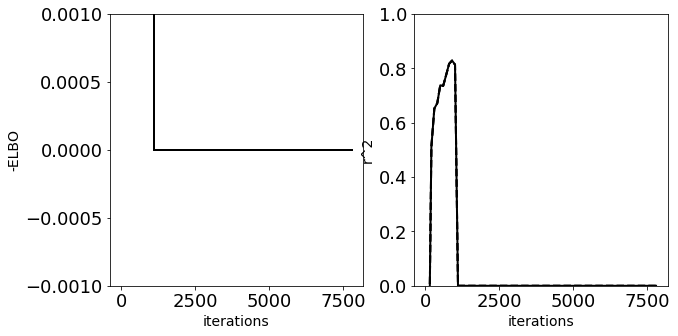

In [14]:
fontsize = 14;
its = np.arange(0, check_rate*final_ind, check_rate);

plt.figure(figsize=(10,5));
# KL
plt.subplot(1,2,1);
plt.plot(its, mean_elbos, 'k', lw=2);
min_val = np.min(mean_elbos-std_elbos);
if (model=='EFN'):
    plt.plot(its, mean_elbos+std_elbos,'k--',lw=2);
    plt.plot(its, mean_elbos-std_elbos,'k--',lw=2);
    std_mag = np.max(std_elbos);
    max_val = min_val + 3*std_mag;
else:
    max_val = np.max(mean_elbos);
plt.ylim([min_val, max_val])
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('-ELBO', fontsize=fontsize);


# r2
plt.subplot(1,2,2);
plt.plot(its, mean_R2s,'k', lw=2);
min_val = max(np.min(mean_R2s-std_R2s), 0);
if (model=='EFN'):
    plt.plot(its, mean_R2s+std_R2s,'k--',lw=2);
    plt.plot(its, mean_R2s-std_R2s,'k--',lw=2);
plt.ylim([min_val, 1])
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('r^2', fontsize=fontsize);

plt.show();